In [5]:
import boost_histogram as bh
import numpy as np
import matplotlib.pyplot as plt
import uproot
import mplhep as hep
import matplotlib as mpl
from copy import deepcopy

In [6]:
mpl.rcParams['axes.linewidth'] = 0
mpl.rcParams['lines.linewidth'] = 0
mpl.rcParams['patch.linewidth'] = 0

In [7]:
plot_groups = {
    "VV":{
    	"names":["qqzz","ggzz_2e2mu","ggzz_2e2nu","ggzz_2e2tau","ggzz_2mu2nu","ggzz_2mu2tau","ggzz_4e","ggzz_4mu","ggzz_4tau","wz"],
    	"color":'tab:blue',
    	"label":"VV"
    },
    "VG":{  
    	"names":["zgtollg","wgtolnug"],
    	"color":'tab:green',
    	"label":"VG"
    },
    "VVV":{
    	"names":["www","wwz","zzz","wzz"],
    	"color":'tab:purple',
    	"label":"VVV"
    },
    "Top":{
    	"names":["ttgjets", "ttztollnunu", "ttztoll", "ttwjetstolnu", "tttt", "tZq_ll", "st antitop", "st top"],
    	"color":'tab:orange',
    	"label":"Top"
    }
}

In [8]:
def _make_error_boxes(hist=None, facecolor='none', edgecolor='grey', alpha=0.9, hatch='\\\\',  **kwargs):
    _x = hist.axes.edges[0][:-1]
    _x_width = hist.axes.widths[0]
    _y = hist.values() - np.sqrt(hist.variances())
    _y_width = 2 * np.sqrt(hist.variances())
    _err_boxes = [mpl.patches.Rectangle((_x_i, _y_i), _x_width_i, _y_width_i) for _x_i, _y_i, _x_width_i, _y_width_i in zip(_x, _y, _x_width, _y_width)]
    _pc = mpl.collections.PatchCollection(_err_boxes, facecolor=facecolor, alpha=alpha, edgecolor=edgecolor, label='Stat Unc.', hatch=hatch)

    _err_box_proxy = mpl.patches.Patch(facecolor=facecolor, alpha=alpha, hatch=hatch, label='Stat Unc.')
    return _pc, _err_box_proxy

def _make_ratio(h1, h2):
    h1_sq = h1.values() * h1.values()
    h2_sq = h2.values() * h2.values()
    array_ratio = np.divide(h1.values(), h2.values(), out=np.zeros_like(h1.values()), where=h2.values()!=0)
    array_ratio_err = np.divide(h1.variances(), h1_sq, out=np.zeros_like(h1_sq), where=h1.values()!=0) + np.divide(h2.variances(), h2_sq, out=np.zeros_like(h2_sq), where=h2.values()!=0)
    array_bin = h1.axes.edges[0]
    # print(h1.variances() * h1.values() * h1.values() + h2.variances() * h2.values() * h2.values()) / (h2.values() * h2.values())
    h_ratio = bh.numpy.histogram([0], bins=array_bin, density=False, weights=1, histogram=bh.Histogram, storage=bh.storage.Weight())
    h_ratio[...] = np.stack([array_ratio, array_ratio_err], axis=-1)
    return h_ratio


In [11]:
file_path     = "root_files/freezed/aQGC_2018.root"
year='2018'
file          = uproot.open(file_path)
hists_data    = {}
hists_mc      = {}
hists_aQGC    = {}
hists_mcgroup = {}
hists_flep    = {}
hists_fpho    = {}

import Control_pad as cp
channel_map = cp.channel_map
channel = cp.channel
UpDown_map = cp.UpDown_map
filelist_data = cp.filelist_data
filelist_MC = cp.filelist_MC
branch = cp.branch
lumi = cp.lumi_RunII

for group in plot_groups:
    hists_mcgroup[f'{group}'] = {}

branch_name = "WZG_mllla"
plotbranch = branch[branch_name]['name']

# data
hists_data = file[f'{channel_map[channel]}_{plotbranch}_data_None'].to_boost()

# fake-lep
hists_flep = file[f'{channel_map[channel]}_{plotbranch}_FakeLep_None'].to_boost()

# fake-pho
hists_fpho = file[f'{channel_map[channel]}_{plotbranch}_FakePho_None'].to_boost()

# mc bkgs
for group in plot_groups:
    hists_mcgroup[f'{group}'] = file[f'{channel_map[channel]}_{plotbranch}_{group}_None'].to_boost()

# mc sig (aQGC)
hists_aQGC_rwt105  = uproot.open("freezed/aQGC_2018_rwt105.root")["WZG_WZG_mllla_aQGC_None"].to_boost()
#hists_aQGC_rwt109  = uproot.open("freezed/aQGC_2018_rwt109.root")["WZG_WZG_mllla_aQGC_None"].to_boost()
#hists_aQGC_rwt110  = uproot.open("freezed/aQGC_2018_rwt110.root")["WZG_WZG_mllla_aQGC_None"].to_boost()
hists_aQGC_allzero = file["WZG_WZG_mllla_aQGC_None"].to_boost()

C:\Users\USER\AppData\Local\Temp\ipykernel_12592\2801056487.py:103: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  handles, labels = axs[0].get_legend_handles_labels()


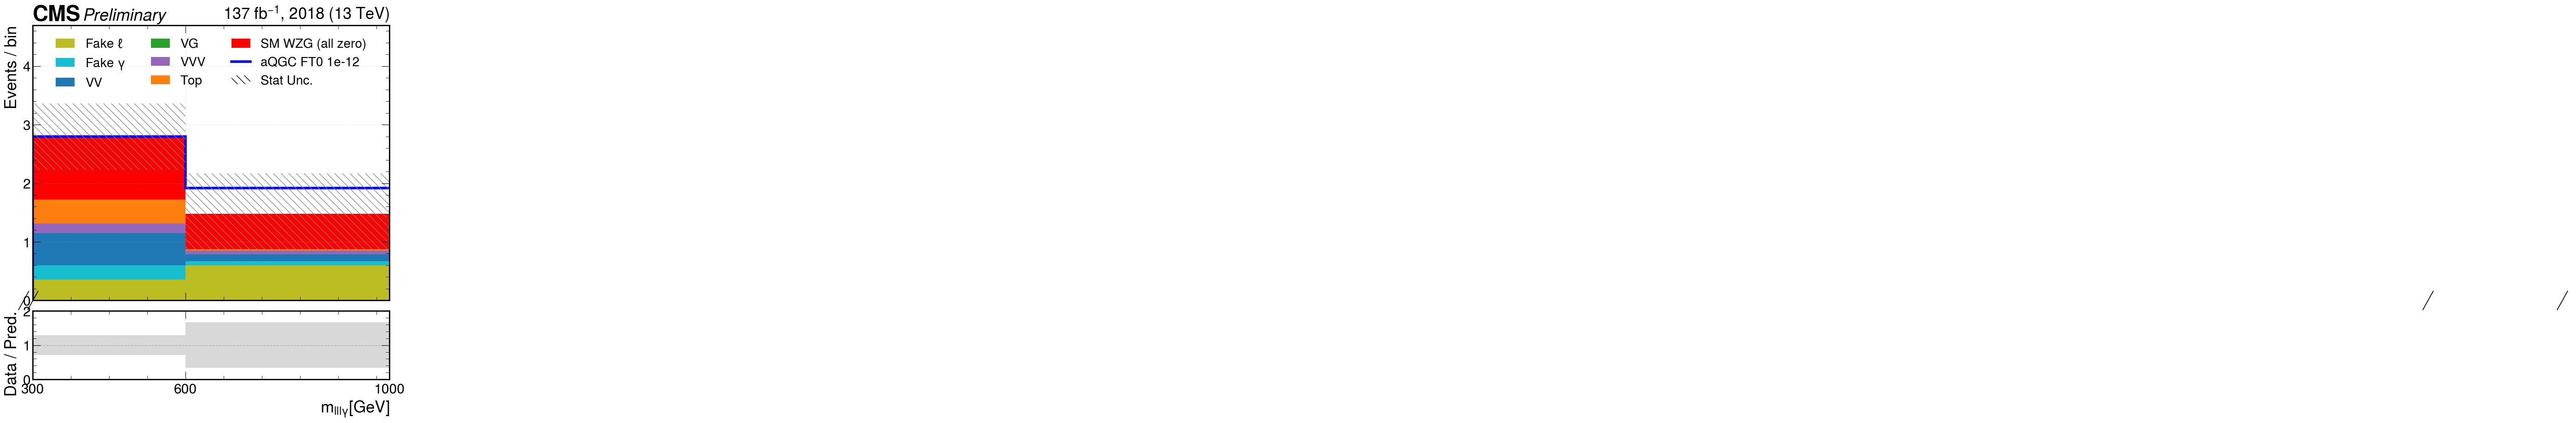

In [12]:
# create axs
plt.style.use(hep.style.CMS)
fig, axs = plt.subplots(
    2, 1,
    sharex = True,
    gridspec_kw = {'height_ratios' : [4,1]},
    figsize = (10, 10)
)
fig.subplots_adjust(hspace=0.06)

# create stack 
stack_list = []
color = []
label = []

# >> add fake-lep
stack_list.append(hists_flep)
hist_pred = deepcopy(hists_flep)
color.append('tab:olive')
label.append('Fake $\ell$')

# >> add fake-pho
if channel in [0,1,2,3,4,20,21,22,23,24,30,31,32]:
    stack_list.append(hists_fpho)
    hist_pred += hists_fpho
    color.append('tab:cyan')
    label.append('Fake $\gamma$')
# >> add mc bkgs
for group in plot_groups:
    stack_list.append(hists_mcgroup[group])
    hist_pred += hists_mcgroup[group]
    color.append(plot_groups[group]['color'])
    label.append(plot_groups[group]['label'])
    pass

# >> add mc sig (aQGC all zero)
stack_list.append(hists_aQGC_allzero)
color.append('red')
label.append('SM WZG (all zero)')

# plot data
if channel not in [0,1,2,3,4]:
    hep.histplot(
        hists_data, 
        color = 'black',
        label = 'Data',
        histtype='errorbar',
        # xerr = True,
        yerr = True,
        binticks = True,
        ax = axs[0]
    )
# plot stack
hep.histplot(
    stack_list,
    stack=True,
    histtype = 'fill',
    color = color,
    label = label,
    binticks = True,
    ax = axs[0]
)


stack_list_and_aQGC_rwt105 = deepcopy(hist_pred)
stack_list_and_aQGC_rwt105+=hists_aQGC_rwt105
hep.histplot(
    stack_list_and_aQGC_rwt105,
    histtype = 'step',
    color = 'blue',
    label = 'aQGC FT0 1e-12',
    linewidth = 4,
    binticks = True,
    yerr=False,
    ax = axs[0]
)


# plot errorbar
hist_pred += hists_aQGC_allzero
pc_pred, pred_err_box_proxy = _make_error_boxes(ax=axs[0], hist=hist_pred)
axs[0].add_collection(pc_pred)

# plot ratio
if channel not in [0,1,2,3,4]:
    hist_ratio = make_ratio(hists_data, hist_pred)
    hep.histplot(
        hist_ratio, 
        color = 'black',
        label = 'Data',
        histtype='errorbar',
        # xerr = True,
        yerr = True,
        binticks = True,
        ax = axs[1]
    )

hist_pred_ratio = _make_ratio(hist_pred, hist_pred)
pc_ratio, ratio_err_box_proxy = _make_error_boxes(ax=axs[1], hist=hist_pred_ratio, hatch=None, facecolor='grey', alpha=0.3)
axs[1].add_collection(pc_ratio)

# Add label and set axes style
handles, labels = axs[0].get_legend_handles_labels()
handles.append(pred_err_box_proxy)
labels.append('Stat Unc.')
axs[0].legend(handles=handles, loc=9, ncol=3, fontsize=20)
axs[0].grid(axis='both', which='major', linestyle='--', linewidth=1.0, alpha=0.2)
axs[1].grid(axis='y', which='major', linestyle='--', linewidth=1.0, alpha=0.9)
axs[0].set_ylabel(f'Events / bin', fontsize=25)
axs[0].set_ylim(0, axs[0].get_ylim()[1]*1.6)
axs[1].set_xlabel(f'${branch[branch_name]["axis_name"]}$', fontsize=25)
axs[1].set_ylabel(f'Data / Pred.', fontsize=25)
axs[1].set_ylim(0, 2)
axs[1].set_xlim(300, 1000)
axs[1].set_xticks([300,600,1000])
axs[0].set_xlim(300, 1000)
axs[0].set_xticks([300,600,1000])
hep.cms.label('Preliminary', data=True, lumi=lumi, year=year, ax=axs[0])
#plt.show()
plt.savefig("WZG_WZG_mllla_None_2018.png")
plt.savefig("WZG_WZG_mllla_None_2018.pdf")